<a href="https://colab.research.google.com/github/Anshu00027/pde_sae/blob/main/SAE_PDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
nu = 1/4

class PINN(nn.Module):
    def __init__(self, layers, activation=nn.Tanh):
        super().__init__()
        net = []
        for i in range(len(layers)-2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(activation())
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net)

    def forward(self, x: torch.Tensor) :
        return self.net(x)


# PDE loss
def pde_loss(model, x, y, z, t):
    x = x.clone().detach().requires_grad_(True)
    y = y.clone().detach().requires_grad_(True)
    z = z.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)
    u = model(torch.cat([x, y, z, t], dim=1))

    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_z = torch.autograd.grad(u, z, torch.ones_like(u), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    u_zz = torch.autograd.grad(u_z, z, torch.ones_like(u_z), create_graph=True)[0]

    residual = u_t + u*(u_x + u_y + u_z) - nu*(u_xx + u_yy + u_zz)
    return torch.mean(residual**2)

# IC loss
def ic_loss(model, x, y, z):
    u0 = model(torch.cat([x, y, z, torch.zeros_like(x)], dim=1))
    u0_exact = 1.0 / (1 + torch.exp((x + y + z)/(2*nu)))
    return torch.mean((u0 - u0_exact)**2)

# Total loss
def total_loss(model, x_int, y_int, z_int, t_int, x_ic, y_ic, z_ic):
    return pde_loss(model, x_int, y_int, z_int, t_int) + ic_loss(model, x_ic, y_ic, z_ic)

def train_adamw(model, x_int, y_int, z_int, t_int, x_ic, y_ic, z_ic,
                x_test, y_test, z_test, t_test, x_ic_test, y_ic_test, z_ic_test,
                epochs=5000, lr=1e-3, weight_decay=1e-4):

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-04)
    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = total_loss(model, x_int, y_int, z_int, t_int, x_ic, y_ic, z_ic)
        loss.backward()
        optimizer.step()
        train_loss_history.append(loss.item())

        test_loss = total_loss(model, x_test, y_test, z_test, t_test, x_ic_test, y_ic_test, z_ic_test).item()
        test_loss_history.append(test_loss)

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Train Loss = {loss.item():.3e}, Test Loss = {test_loss:.3e}")

    return train_loss_history, test_loss_history


if __name__ == "__main__":
    # Interior training points
    n_int = 6
    x_int = torch.linspace(0,1,n_int).view(-1,1)
    y_int = torch.linspace(0,1,n_int).view(-1,1)
    z_int = torch.linspace(0,1,n_int).view(-1,1)
    t_int = torch.linspace(0,1,n_int+1)[1:].view(-1,1)  # exclude t=0
    X, Y, Z, T = torch.meshgrid(x_int.squeeze(), y_int.squeeze(), z_int.squeeze(), t_int.squeeze(), indexing='ij')
    x_int_flat, y_int_flat, z_int_flat, t_int_flat = X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1), T.reshape(-1,1)

    # IC points
    n_ic = 5
    x_ic = torch.linspace(0,1,n_ic).view(-1,1)
    y_ic = torch.linspace(0,1,n_ic).view(-1,1)
    z_ic = torch.linspace(0,1,n_ic).view(-1,1)
    X_ic, Y_ic, Z_ic = torch.meshgrid(x_ic.squeeze(), y_ic.squeeze(), z_ic.squeeze(), indexing='ij')
    x_ic_flat, y_ic_flat, z_ic_flat = X_ic.reshape(-1,1), Y_ic.reshape(-1,1), Z_ic.reshape(-1,1)

    # Test points
    n_test = 3
    x_test = torch.linspace(0,1,n_test).view(-1,1)
    y_test = torch.linspace(0,1,n_test).view(-1,1)
    z_test = torch.linspace(0,1,n_test).view(-1,1)
    t_test = torch.linspace(0,1,n_test+1)[1:].view(-1,1)
    X_t, Y_t, Z_t, T_t = torch.meshgrid(x_test.squeeze(), y_test.squeeze(), z_test.squeeze(), t_test.squeeze(), indexing='ij')
    x_test_flat, y_test_flat, z_test_flat, t_test_flat = X_t.reshape(-1,1), Y_t.reshape(-1,1), Z_t.reshape(-1,1), T_t.reshape(-1,1)

    # Test IC points
    n_ic_test = 3
    x_ic_test = torch.linspace(0,1,n_ic_test).view(-1,1)
    y_ic_test = torch.linspace(0,1,n_ic_test).view(-1,1)
    z_ic_test = torch.linspace(0,1,n_ic_test).view(-1,1)
    X_ic_t, Y_ic_t, Z_ic_t = torch.meshgrid(x_ic_test.squeeze(), y_ic_test.squeeze(), z_ic_test.squeeze(), indexing='ij')
    x_ic_test_flat, y_ic_test_flat, z_ic_test_flat = X_ic_t.reshape(-1,1), Y_ic_t.reshape(-1,1), Z_ic_t.reshape(-1,1)

    # Model
    model = PINN([4, 8,8, 1])

    # Train with AdamW (lr=1e-3)
    train_loss, test_loss = train_adamw(model,
        x_int_flat, y_int_flat, z_int_flat, t_int_flat,x_ic_flat, y_ic_flat, z_ic_flat,
        x_test_flat, y_test_flat, z_test_flat, t_test_flat,x_ic_test_flat, y_ic_test_flat, z_ic_test_flat,
        epochs=10000, lr=1e-3)

    # Evaluate Relative L2 error
    n_eval = 10
    x_eval = torch.linspace(0,1,n_eval).view(-1,1)
    y_eval = torch.linspace(0,1,n_eval).view(-1,1)
    z_eval = torch.linspace(0,1,n_eval).view(-1,1)
    t_eval = torch.linspace(0,1,n_eval).view(-1,1)
    X_e, Y_e, Z_e, T_e = torch.meshgrid(x_eval.squeeze(), y_eval.squeeze(), z_eval.squeeze(), t_eval.squeeze(), indexing='ij')
    x_e, y_e, z_e, t_e = X_e.reshape(-1,1), Y_e.reshape(-1,1), Z_e.reshape(-1,1), T_e.reshape(-1,1)
    u_pred = model(torch.cat([x_e, y_e, z_e, t_e], dim=1))
    u_exact = 1.0 / (1 + torch.exp((x_e + y_e + z_e - 1.5*t_e)/(2*nu)))
    rel_L2 = torch.norm(u_pred - u_exact)/torch.norm(u_exact)
    print("Relative L2 Error:", rel_L2.item())


Epoch 0: Train Loss = 1.915e-02, Test Loss = 2.488e-02
Epoch 500: Train Loss = 9.261e-04, Test Loss = 1.679e-03
Epoch 1000: Train Loss = 5.624e-05, Test Loss = 1.051e-04
Epoch 1500: Train Loss = 2.199e-05, Test Loss = 4.338e-05
Epoch 2000: Train Loss = 1.240e-05, Test Loss = 2.473e-05
Epoch 2500: Train Loss = 7.589e-06, Test Loss = 1.505e-05
Epoch 3000: Train Loss = 4.935e-06, Test Loss = 9.665e-06
Epoch 3500: Train Loss = 3.299e-06, Test Loss = 6.309e-06
Epoch 4000: Train Loss = 2.261e-06, Test Loss = 4.215e-06
Epoch 4500: Train Loss = 1.592e-06, Test Loss = 2.908e-06
Epoch 5000: Train Loss = 1.152e-06, Test Loss = 2.077e-06
Epoch 5500: Train Loss = 8.604e-07, Test Loss = 1.548e-06
Epoch 6000: Train Loss = 6.635e-07, Test Loss = 1.203e-06
Epoch 6500: Train Loss = 5.277e-07, Test Loss = 9.717e-07
Epoch 7000: Train Loss = 4.303e-07, Test Loss = 8.089e-07
Epoch 7500: Train Loss = 3.590e-07, Test Loss = 6.903e-07
Epoch 8000: Train Loss = 3.049e-07, Test Loss = 5.997e-07
Epoch 8500: Train 

In [ ]:
import torch
import numpy as np

# Interior points
inputs_int = torch.cat([x_int_flat, y_int_flat, z_int_flat, t_int_flat], dim=1)
t_ic_flat = torch.zeros_like(x_ic_flat)
inputs_ic  = torch.cat([x_ic_flat, y_ic_flat, z_ic_flat, t_ic_flat], dim=1)

# All training points
inputs_train = torch.cat([inputs_int, inputs_ic], dim=0)

# Dictionary to store activations
layer_data = {}

def save_last_layer_hook(module, input, output):
    # Only save activations now
    layer_data['activations'] = output.detach().clone()  # activations of last hidden layer

# Register hook on last hidden layer
hook_handle = model.net[-2].register_forward_hook(save_last_layer_hook)

# Forward pass
_ = model(inputs_train)

# Save only activations
activations_array = layer_data['activations'].cpu().numpy()
print("Shape of activations array:", activations_array.shape)

np.save("last_layer_activations.npy", activations_array)

# Remove the hook
hook_handle.remove()


Shape of activations array: (1421, 8)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Use all activations from last hidden layer
hidden_tensor = torch.tensor(activations_array, dtype=torch.float32)

# Dataset
dataset = TensorDataset(hidden_tensor, hidden_tensor)
dataloader = DataLoader(dataset, batch_size=49, shuffle=True)

# Sparse Autoencoder definition
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda=1e-3, sparsity_target=0.001):
        super().__init__()
        # self.xavier_norm_init = xavier_norm_init
        self.encoder = nn.Sequential(
            nn.Linear(in_dims, h_dims),
            nn.Sigmoid()
        )

        # if self.xavier_norm_init:
        #     nn.init.xavier_uniform_(self.encoder[0].weight)
        #     nn.init.constant_(self.encoder[0].bias, 0)


        self.decoder = nn.Sequential(
            nn.Linear(h_dims, in_dims),
            nn.Tanh()
        )

        # if self.xavier_norm_init:
        #     nn.init.xavier_uniform_(self.decoder[0].weight)
        #     nn.init.constant_(self.decoder[0].bias, 0)

        self.sparsity_lambda = sparsity_lambda
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1-epsilon)
        kl_div = rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat))
        return self.sparsity_lambda * torch.sum(kl_div)

    def loss_function(self, decoded, x, encoded):
        mse_loss = nn.functional.mse_loss(decoded, x)
        return mse_loss + self.sparsity_penalty(encoded)

# Initialize and train
in_dims = hidden_tensor.shape[1]
h_dims = 25
sae = SparseAutoencoder(in_dims, h_dims)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sae.to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

# Training

n_epochs = 100
last_batch_encoded = None  # store last batch activations

for epoch in range(n_epochs):
    total_loss = 0
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        encoded, decoded = sae(batch_x)
        loss = sae.loss_function(decoded, batch_x, encoded)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Keep last batch activations
        last_batch_encoded = encoded.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {total_loss/len(dataloader):.6f}")

# After training
np.save("last_batch_encoded.npy", last_batch_encoded)
print("Saved last mini-batch encoded activations:", last_batch_encoded.shape)


# Save the encoded representation
with torch.no_grad():
    encoded, _ = sae(hidden_tensor.to(device))

encoded = encoded.cpu().numpy()
np.save("train_last_hidden_encoded.npy", encoded)
print("Saved SAE encoded features shape:", encoded.shape)


Epoch 1/100 - Loss: 0.360545
Epoch 11/100 - Loss: 0.044491
Epoch 21/100 - Loss: 0.020073
Epoch 31/100 - Loss: 0.015548
Epoch 41/100 - Loss: 0.012913
Epoch 51/100 - Loss: 0.011069
Epoch 61/100 - Loss: 0.009661
Epoch 71/100 - Loss: 0.008529
Epoch 81/100 - Loss: 0.007597
Epoch 91/100 - Loss: 0.006804
Saved last mini-batch encoded activations: (49, 25)
Saved SAE encoded features shape: (1421, 25)


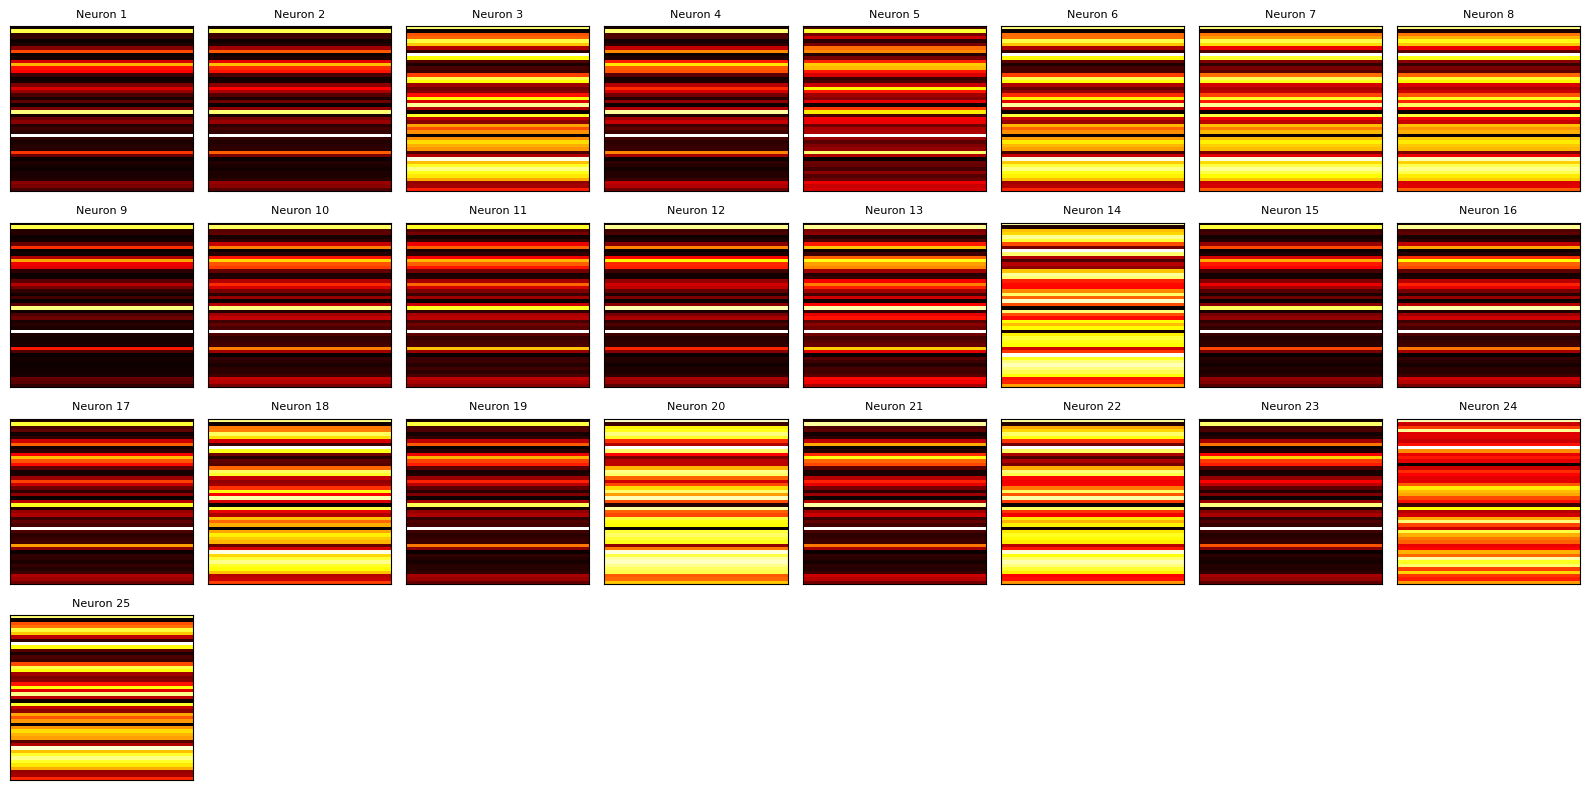

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_last_batch_activations(activations, num_neurons, neurons_per_row, save_path=None):
    num_rows = (num_neurons + neurons_per_row - 1) // neurons_per_row
    fig, axes = plt.subplots(num_rows, neurons_per_row, figsize=(neurons_per_row * 2, num_rows * 2))
    axes = axes.flatten()

    for i in range(num_neurons):
        if i >= activations.shape[1]:
            break
        ax = axes[i]
        # Each neuron activation across the last batch samples
        ax.imshow(activations[:, i].reshape(-1, 1), aspect='auto', cmap='hot')
        ax.set_title(f'Neuron {i+1}', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

# call
plot_last_batch_activations(last_batch_encoded, num_neurons=h_dims, neurons_per_row=8, save_path="last_batch_activations.png")


## with xavier initialization

In [ ]:

# Use all activations from last hidden layer
hidden_tensor = torch.tensor(activations_array, dtype=torch.float32)

# Dataset (input = output)
dataset = TensorDataset(hidden_tensor, hidden_tensor)
dataloader = DataLoader(dataset, batch_size=49, shuffle=True)

# Sparse Autoencoder definition
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda=1e-3, sparsity_target=0.001,xavier_norm_init=True):
        super().__init__()
        self.xavier_norm_init = xavier_norm_init
        self.encoder = nn.Sequential(
            nn.Linear(in_dims, h_dims),
            nn.Sigmoid()
        )

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)
            nn.init.constant_(self.encoder[0].bias, 0)


        self.decoder = nn.Sequential(
            nn.Linear(h_dims, in_dims),
            nn.Tanh()
        )

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)
            nn.init.constant_(self.decoder[0].bias, 0)

        self.sparsity_lambda = sparsity_lambda
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1-epsilon)
        kl_div = rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat))
        return self.sparsity_lambda * torch.sum(kl_div)

    def loss_function(self, decoded, x, encoded):
        mse_loss = nn.functional.mse_loss(decoded, x)
        return mse_loss + self.sparsity_penalty(encoded)

# Initialize and train
in_dims = hidden_tensor.shape[1]
h_dims = 25
sae = SparseAutoencoder(in_dims, h_dims)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sae.to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

# Training

n_epochs = 100
last_batch_encoded = None

for epoch in range(n_epochs):
    total_loss = 0
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        encoded, decoded = sae(batch_x)
        loss = sae.loss_function(decoded, batch_x, encoded)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Keep last batch activations
        last_batch_encoded = encoded.detach().cpu().numpy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {total_loss/len(dataloader):.6f}")

# After training
np.save("last_batch_encoded.npy", last_batch_encoded)
print("Saved last mini-batch encoded activations:", last_batch_encoded.shape)


# Save the encoded representation
with torch.no_grad():
    encoded, _ = sae(hidden_tensor.to(device))

encoded = encoded.cpu().numpy()
np.save("train_last_hidden_encoded.npy", encoded)
print("Saved SAE encoded features shape:", encoded.shape)


Epoch 1/100 - Loss: 0.818570
Epoch 11/100 - Loss: 0.047062
Epoch 21/100 - Loss: 0.024548
Epoch 31/100 - Loss: 0.019011
Epoch 41/100 - Loss: 0.016674
Epoch 51/100 - Loss: 0.014910
Epoch 61/100 - Loss: 0.013396
Epoch 71/100 - Loss: 0.012071
Epoch 81/100 - Loss: 0.010898
Epoch 91/100 - Loss: 0.009854
Saved last mini-batch encoded activations: (49, 25)
Saved SAE encoded features shape: (1421, 25)


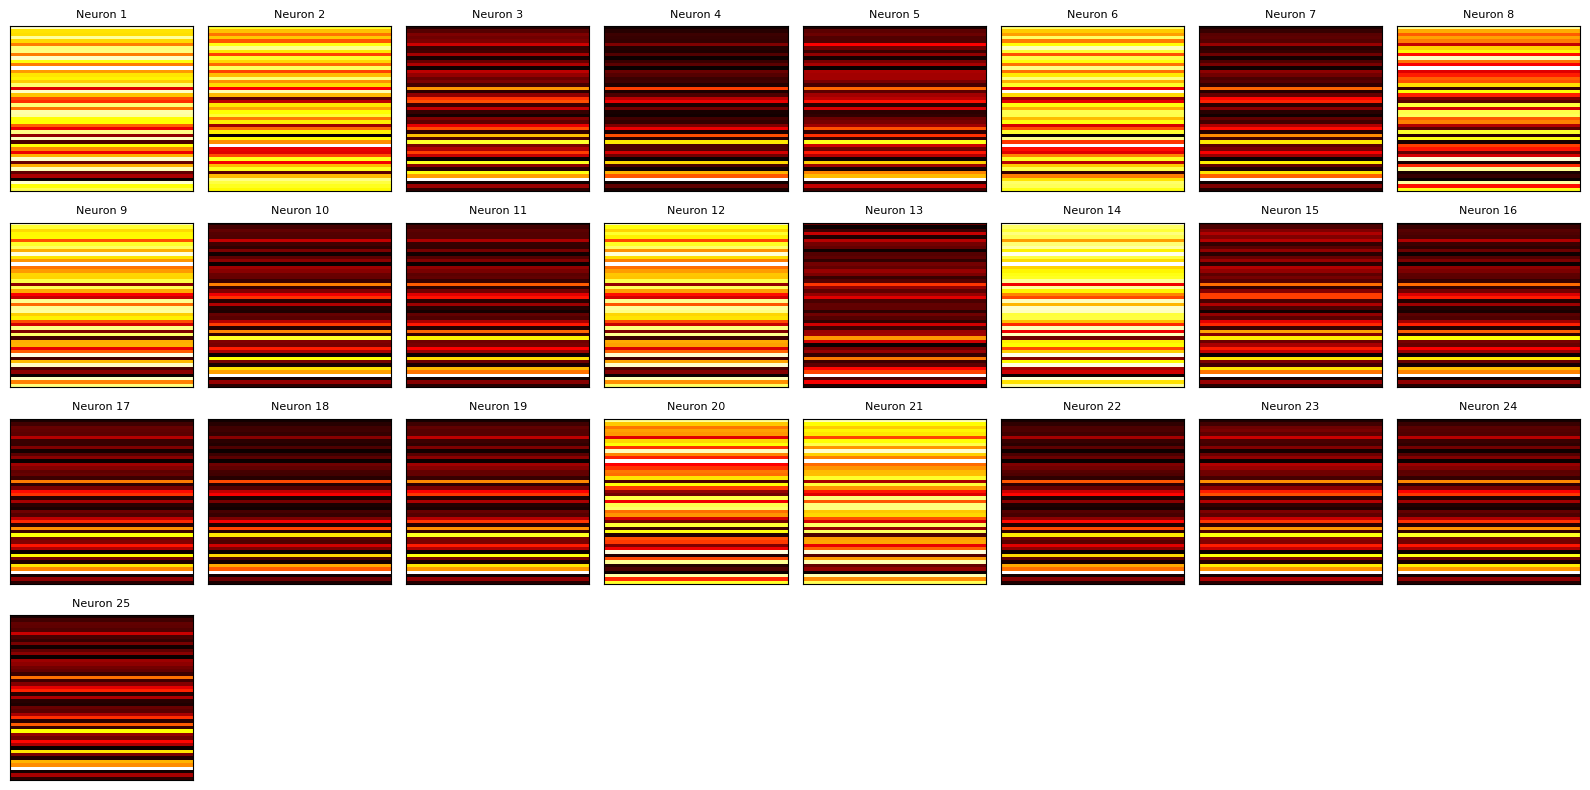

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_last_batch_activations(activations, num_neurons, neurons_per_row, save_path=None):
    num_rows = (num_neurons + neurons_per_row - 1) // neurons_per_row
    fig, axes = plt.subplots(num_rows, neurons_per_row, figsize=(neurons_per_row * 2, num_rows * 2))
    axes = axes.flatten()

    for i in range(num_neurons):
        if i >= activations.shape[1]:
            break
        ax = axes[i]
        # Each neuron activation across the last batch samples
        ax.imshow(activations[:, i].reshape(-1, 1), aspect='auto', cmap='hot')
        ax.set_title(f'Neuron {i+1}', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

# call
plot_last_batch_activations(last_batch_encoded, num_neurons=h_dims, neurons_per_row=8, save_path="last_batch_activations.png")
